In [1]:
import os
import re
import glob 
import numpy as np
import numpy.linalg as la
import astropy.units as u
from astropy.io import fits
import scipy.fftpack as sci
from astropy.time import Time
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max
from scipy.ndimage import maximum_filter, label, find_objects

In [40]:
def pws(image_01, image_02, dark):
    #--------------------------------
    # Carrega e abre os dados do fits
    #--------------------------------
    hdul = fits.open(image_01)
    header_data = hdul[0].header
    image_data = hdul[0].data

    hdul_01 = fits.open(image_02)
    header_data_01 = hdul_01[0].header
    image_data_01 = hdul_01[0].data

    hdul_dark = fits.open(dark)
    header_dark = hdul_dark[0].header
    image_dark = hdul_dark[0].data

    #--------------------------------------
    # Função que gera o Fourier master dark
    #--------------------------------------
    num_frames, width, height = image_dark.shape
    fourier_master_dark = np.zeros((width, height))

    for i in range(num_frames):
        image = image_dark[i]
        fft_dark = sci.fft2(image)
        fft_normalized_dark = np.abs(fft_dark)
        fft_normalized_dark /= fft_normalized_dark.max()
        fft_shifted_dark = sci.fftshift(fft_normalized_dark)

        fourier_master_dark += fft_shifted_dark ** 2

    fourier_master_dark /= num_frames

    #------------------------------------------------
    # Função que calcula a PWS e extrai o master dark
    #------------------------------------------------
    def process_fit_cub(data, dark):
        num_frames, width, height = data.shape
        PWS = np.zeros((width, height))

        for i in range(num_frames):
            image = data[i] 
     
            fft = sci.fft2(image)
            fft_normalized = np.abs(fft)
            fft_normalized /= fft_normalized.max()
            fft_shifted = sci.fftshift(fft_normalized)
        
            power_spectrum = fft_shifted ** 2 - dark
        
            PWS += power_spectrum

        return PWS

    #----------------
    # Calculo das PWS
    #----------------
    PWS_01 = process_fit_cub(image_data, fourier_master_dark)
    PWS_02 = process_fit_cub(image_data_01, fourier_master_dark)

    PWS_mean = (PWS_01 + PWS_02) / 2

    return PWS_mean, PWS_01, PWS_02, fourier_master_dark

def le_image(image_01, image_02, dark):
    hdul = fits.open(image_01)
    header_data = hdul[0].header
    image_data = hdul[0].data

    hdul_01 = fits.open(image_02)
    header_data_01 = hdul_01[0].header
    image_data_01 = hdul_01[0].data

    hdul_space_dark = fits.open(dark)
    header_space_dark_ = hdul_space_dark[0].header
    image_space_dark = hdul_space_dark[0].data

    num_frames, width, height = image_space_dark.shape
    space_dark = np.zeros((width, height))

    #-------------------------------------------------------------------------------------------------
    # Looping para carregar cada imagem do fits, aplicar a transformada e calcular o PS do master dark
    #-------------------------------------------------------------------------------------------------
    for i in range(num_frames):
        image_space = image_space_dark[i]
        space_dark += image_space

    space_dark /= num_frames

    #---------------------------------------------------------------------
    # Função que gera as imagens de longa exposição e extrai o master dark
    #---------------------------------------------------------------------
    def process_fit_cub(data, dark_space):
        num_frames, width, height = data.shape
        LE_image = np.zeros((width, height))

        for i in range(num_frames):
            image = data[i] - dark_space
            LE_image += image

        return LE_image

    #---------------------------------------
    # Calculo das imagens de longa exposição
    #---------------------------------------
    LE_01 = process_fit_cub(image_data, space_dark)
    LE_02 = process_fit_cub(image_data_01, space_dark)


    LE_image_mean = (LE_01 + LE_02) / 2

    return LE_image_mean, space_dark

def acf(pws_01, pws_02, psf):
    #--------------------------------
    # Carrega e abre os dados do fits
    #--------------------------------
    hdul_pws_I = fits.open(pws_01)  # Mostra informações sobre as extensões do FITS
    header_pws_I = hdul_pws_I[0].header
    pws_I = hdul_pws_I[0].data  # Normalmente a imagem está na primeira extensão

    hdul_pws_I_01 = fits.open(pws_02)
    header_pws_I_01 = hdul_pws_I_01[0].header
    pws_I_01 = hdul_pws_I_01[0].data

    hdul_psf_I = fits.open(psf) 
    header_psf_I = hdul_psf_I[0].header
    psf_I = hdul_psf_I[0].data

    #---------------------------
    # Função que calcula as ACFs
    #---------------------------
    def ACF_calculation(PWS , PSF):
        with np.errstate(divide='ignore', invalid='ignore'): # Faz com que o programa ignore os avisos de erro na divisão (/0) e também valores inválidos (NaN ou infinito).
            sci_I = np.divide(PWS, PSF, out=np.zeros_like(PWS), where=PSF != 0) # Opera a divisão entre PWS e PSF, mas somente onde PSF != 0, para os casos em que PSF == 0 o valor da ACF retorna também zero.
        fft_I = sci.fft2(sci_I) # Fazendo a transformada bidimensional
        normalized_fft_I = np.abs(fft_I) # Pegando os valores absolutos da FFT2
        normalized_fft_I /= normalized_fft_I.max() # Normalizando a FFT2 dividindo a FFT2 pelo seu valor máximo
        ACF = sci.fftshift(normalized_fft_I)

        return ACF

    ACF_01 = ACF_calculation(pws_I, psf_I)
    ACF_02 = ACF_calculation(pws_I_01, psf_I)

    ACF_mean = (ACF_01 + ACF_02) / 2

    return ACF_mean

def HR_image(image_01, image_02, dark):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    HR_hdul = fits.open(image_01)
    HR_header = HR_hdul[0].header
    HR_data = HR_hdul[0].data

    HR_hdul_01 = fits.open(image_02)
    HR_header_01 = HR_hdul_01[0].header
    HR_data_01 = HR_hdul_01[0].data

    hdul_space_dark = fits.open(dark)
    header_space_dark_ = hdul_space_dark[0].header
    image_space_dark = hdul_space_dark[0].data

    num_frames, width, height = image_space_dark.shape
    space_dark = np.zeros((width, height))

    #-------------------------------------------------------------------------------------------------
    # Looping para carregar cada imagem do fits, aplicar a transformada e calcular o PS do master dark
    #-------------------------------------------------------------------------------------------------
    for i in range(num_frames):
        image_space = image_space_dark[i]
        space_dark += image_space

    space_dark /= num_frames

    #------------------------------------------------
    # Função que calcula as imagens de alta resolução
    #------------------------------------------------
    def hight_resolution_image(data, dark):
        num_frames, width, height = data.shape
        centro_y, centro_x = height//2, width//2
    
        AR_image = np.zeros((width, height))
    
        for i in range(num_frames):
            image = data[i] - dark # Pega a i-ésima imagem
            y_max, x_max = np.unravel_index(np.argmax(image), image.shape)

            dx = centro_x - x_max
            dy = centro_y - y_max
    
            imagem_alinhada = shift(image, shift=(dy, dx), order=1, mode='constant', cval=0.0) # Linha que alinha o centro das imagens do fits com o da imagem gerada (AR_image)

            AR_image +=imagem_alinhada

        return AR_image

    HR_01 = hight_resolution_image(HR_data, space_dark)
    HR_02 = hight_resolution_image(HR_data_01, space_dark)

    HR_mean = (HR_01 + HR_02) / 2

    return HR_mean

def dist_theta(image):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    hdul_ar = fits.open(image)
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return (x_max, y_max)

#------------------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#------------------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=1, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img) # Filtro dos valores de fluxo que são considerados secundários (0.9%flux_max)

        peaks = peak_local_max(img, min_distance=dist_minima, threshold_abs=limiar, num_peaks=num_picos + 1, exclude_border=False)

        # Extrai os fluxos dos picos encontrados, onde [:, 0] pega as linhas da coluna 0 (y) e [:, 1] pega as linhas da coluna 1(x)
        fluxos = img[peaks[:, 0], peaks[:, 1]]
    
        indices_ord = np.argsort(fluxos)[::-1] # Ordena os valores do fluxo em ordem crescente
        peaks_ord = peaks[indices_ord]
        fluxos_ord = fluxos[indices_ord]  
        

        real_peaks = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(peaks_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in real_peaks):
                real_peaks.append(coord)
            if len(real_peaks) >= num_picos:
                break
    
        real_peaks = np.array(real_peaks)
        selected_flux = img[real_peaks[:, 0], real_peaks[:, 1]]

        # Converte para (x, y) para manter o padrão do restante do código
        pos_xy = np.array([[x, y] for y, x in real_peaks])
    
        return pos_xy

    posicoes = fluxo_secundário(image_ar, 2, dist_minima=1, limiar_relativo=0.009)

    (x_max, y_max) = fluxo_maximo(image_ar)
    posicoes_sec = posicoes[1:]

    altura, largura = image_ar.shape[:2]

    centro_x = largura/2
    centro_y = altura//2

    def distancia(x_c, y_c, x, y):
        d_x = x - x_c
        d_y = y - y_c
        d = np.sqrt((d_x**2) + (d_y)**2)
        theta = np.degrees(np.arctan2(d_x, d_y))
        theta = 180 - theta

        return d, theta
    
    dist, angulo = distancia(centro_x, centro_y, posicoes_sec[0, 0], posicoes_sec[0, 1])

    return dist, angulo

def mag_diff(image):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    hdul_ar = fits.open(image)
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return flux_max

#------------------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#------------------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=1, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img)

        peaks = peak_local_max(img, min_distance=dist_minima, threshold_abs=limiar, num_peaks=num_picos + 1, exclude_border=False)

    # Extrai os fluxos dos picos encontrados, onde [:, 0] pega as linhas da coluna 0 (y) e [:, 1] pega as linhas da coluna 1(x)
        fluxo = img[peaks[:, 0], peaks[:, 1]]
    
        indices_ord = np.argsort(fluxo)[::-1] # Ordena os valores do fluxo em ordem crescente
        peaks_ord = peaks[indices_ord]
        fluxos_ord = fluxo[indices_ord]  
        

        real_peaks = [] # Este looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(peaks_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in real_peaks):
                real_peaks.append(coord)
            if len(real_peaks) >= num_picos:
                break
    
        real_peaks = np.array(real_peaks)
        selected_flux = img[real_peaks[:, 0], real_peaks[:, 1]]

        # Converte para (x, y) para manter o padrão do restante do código
        pos_xy = np.array([[x, y] for y, x in real_peaks])
    
        return selected_flux

    flux_sec = fluxo_secundário(image_ar, 2, dist_minima=1, limiar_relativo=0.009)

    flux_max = fluxo_maximo(image_ar)
    flux_sec = flux_sec[1:]

    def dif_mag(f_1, f_2):
        diferenca_de_magnitude = -2.5*np.log10((f_2/f_1))
        return diferenca_de_magnitude
    
    mag_dif = dif_mag(flux_max, flux_sec[0])
    
    return mag_dif

def seeing(image, ep):
    LE_hdul = fits.open(image)
    LE_header_data = LE_hdul[0].header
    LE_data = LE_hdul[0].data

    def gaussian_2d(xy, amp, x0, y0, sigma_x, sigma_y, offset):
        x, y = xy
        g = offset + amp * np.exp(-(((x-x0)**2)/(2*sigma_x**2) + ((y-y0)**2)/(2*sigma_y**2)))
        return g.ravel()

#------------------------------------------------------
# Determina a posição do pixel mais brilhante da imagem
#------------------------------------------------------
    def pos_max(img):
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape)
        return x_max, y_max

#-------------------------------------------------------------------
# Faz o recorte da região ao redor do ponto mais brilhante da imagem
#-------------------------------------------------------------------
    x_center, y_center = pos_max(LE_data) # Centraliza o corte no pixel mais brilhante
    width, height = LE_data.shape

#--------------------------------
# Coordenadas do ajuste Gaussiano
#-------------------------------- 
    yy, xx = np.indices(LE_data.shape) # Gera uma grade de coordenadas para a imagem.
    initial_guess = (LE_data.max(), x_center, y_center, width / 4, height / 4, np.median(LE_data)) # Parâmetros iniciais para o ajuste gassiano (amp, x, y, sigma_x, sigma_y, offset)

#-------------------
# Ajusta a Gaussiana
#-------------------
    lower_bounds = [   0,       0,      0,      0.1,     0.1,     -np.inf ] # Limite inferior para os parâmetros iniciais.
    upper_bounds = [ np.inf,  width, height,   np.inf,  np.inf,  np.inf ] # Limite superios para os parâmetros iniciais. 

    popt, pcov = curve_fit(gaussian_2d, (xx, yy), LE_data.ravel(), p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=10000) # Faz o ajuste gaussiano na LE_image para então obter os valores de sigma.

#---------------------------
# Extrai os valores de sigma
#---------------------------
    sigma_x, sigma_y = popt[3], popt[4]

#---------------
# Calcula a FWHM
#---------------
    fwhm_x = 2.355 * sigma_x
    fwhm_y = 2.355 * sigma_y
    fwhm_mean = (fwhm_x + fwhm_y) / 2

    escala = ep  # exemplo em arcsec/pixel
    seeing_arcsec = ((fwhm_x + fwhm_y)/2) * escala

    return seeing_arcsec

def position(image):
    hdul_ar = fits.open(image)  # Mostra informações sobre as extensões do FITS
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data  # Normalmente a imagem está na primeira extensão

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return (x_max, y_max)

#---------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#---------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=1, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img) # "filtra" os valores de fluxo que se quer ou não ler.

        peaks = peak_local_max(img, min_distance=dist_minima, threshold_abs=limiar, num_peaks=num_picos + 1, exclude_border=False)

        # Extrai os fluxos dos picos encontrados, onde [:, 0] pega as linhas da coluna 0 (y) e [:, 1] pega as linhas da coluna 1(x)
        fluxos = img[peaks[:, 0], peaks[:, 1]]
    
        indices_ord = np.argsort(fluxos)[::-1] # Ordena os valores do fluxo em ordem crescente
        peaks_ord = peaks[indices_ord]
        fluxos_ord = fluxos[indices_ord]  
        

        real_peaks = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(peaks_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in real_peaks):
                real_peaks.append(coord)
            if len(real_peaks) >= num_picos:
                break
    
        real_peaks = np.array(real_peaks)
        selected_flux = img[real_peaks[:, 0], real_peaks[:, 1]]

        # Converte para (x, y) para manter o padrão do restante do código
        pos_xy = np.array([[x, y] for y, x in real_peaks])

        return pos_xy

    posicoes = fluxo_secundário(image_ar, 2, dist_minima=1, limiar_relativo=0.009)

    (x_max, y_max) = fluxo_maximo(image_ar)
    posicoes_sec = posicoes[1:]

    return (x_max, y_max), posicoes_sec

def julian_epoch(time):
    dt = datetime.fromisoformat(time)
    date = Time(dt, scale='utc')
    epoch = date.jyear

    return epoch

def linear_regression(x_axis, y_axis):
    def Fij(x_axis):
        F = [[1, x,] for x in x_axis]
    
        return np.array(F)

    F = Fij(x_axis)
    F_transp = F.T
    FTy = F_transp @ y_axis
    inv = la.inv(F_transp @ F)
    a = inv @ FTy

    R = F @ a - y_axis
    Dq = R.T @ R

    N = x_axis.size
    M = a.size

    Va = (Dq/(N - M))*inv
    var = np.diag(Va)
    sigma = np.sqrt(var)

    y_pred = F @ a # Valores de y previstos pela F já aplicando os coeficientes an
    SST = np.sum((y_axis - np.mean(y_axis))**2)  # Soma total dos quadrados
    SSR = np.sum((y_axis - y_pred)**2)      # Soma dos quadrados dos resíduos
    r2_score = 1 - (SSR / SST)

    return a, sigma, r2_score, Fij 

----

Optimization code for PWS, Master dark, LE and HR images calculation.

----

In [5]:
filter = 'V'
root_dir = r"D:\22abr23\22abr23"
exit_dir = r"C:\Users\lucas\Desktop\Teste_de_noite"

def all_night_process(root_dir, exit_dir, filter_target):
    # Criar diretórios de saída
    dirs_saida = ['LE', 'HR', 'master_dark', 'PWS', 'PWS/PWS_01_02']
    for dir_name in dirs_saida:
        os.makedirs(os.path.join(exit_dir, dir_name), exist_ok=True)
    
    # Encontrar todos os arquivos FITS
    find_fits = glob.glob(os.path.join(root_dir, "**/*.fits"), recursive=True)
    print(f"Encontrados {len(find_fits)} arquivos FITS")
    
    # Separar imagens science de darks pelo NOME
    science_images = []
    dark_images = []
    for arquivo in find_fits:
        nome_arquivo = os.path.basename(arquivo)
        
        # Pular arquivos que são darks (pelo nome)
        if nome_arquivo.startswith('Dark') or 'dark' in nome_arquivo.lower():
            match = re.search(r'dark(\d+)-\d+\.fits', nome_arquivo.lower())

            if match:
                ganho = int(match.group(1))
                dark_images.append({ 'path': arquivo, 
                                    'gain': ganho})
            continue
            
        science_images.append(arquivo) # Considera qualquer arquivo sem "dark" no nome como objeto de ciência.
    
    print(f"Imagens science encontradas: {len(science_images)}")

    def grouped_images(images, image_filter):
        object_images = {}
    
        for arquivo in images:
            nome_arquivo = os.path.basename(arquivo)
        
            # Extrair RA-DEC do nome.
            match = re.match(r'([A-Za-z\d]+[-+][A-Za-z\d]+(?:_O)?|[A-Za-z]+\d+)-?([A-Za-z])-\d+\.fits', nome_arquivo)
            if not match:
                continue
            
            ra_dec = match.group(1) 
            filtro = match.group(2).upper() 
        
            # Pular o objeto se não for o filtro alvo
            if filtro != image_filter:
                continue
        
            if ra_dec not in object_images: # Adiciona RA e DEC de um arquivo, caso esse não esteja no dicionário de arquivos.
                object_images[ra_dec] = []
        
            object_images[ra_dec].append(arquivo)
    
    # Ordenar as imagens de cada objeto
        for objeto in object_images:
            object_images[objeto].sort()
    
        return object_images

    # Agrupar imagens science por objeto (RA-DEC) e filtro
    object_image = grouped_images(science_images, filter_target)
    
    print(f"Objetos para processar com filtro {filter_target}: {len(object_image)}")

    def image_gain(file_path):
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            return header.get('GAIN', 0)
        
    def extract_name_filter(file_name):
        match = re.search(r'-([A-Za-z])-\d+\.fits', file_name)
        return match.group(1).upper() if match else None
    
    def gain_dark_select(gain_image, dark_images):
        dark_selecionado = None
    
        # Tenta dark com mesmo ganho.
        for dark in dark_images:
            if dark['gain'] == gain_image:
                dark_selecionado = dark['path']
                break
    
        # Se não houver um dark, tenta qualquer um disponível
        if not dark_selecionado and dark_images:
            dark_selecionado = dark_images[0]['path']
    
        return dark_selecionado
    
    def process_single_image(imagem_path, dark_path, saida_dir, objeto, filtro):
        pws_mean, pws_01, pws_02, fourier_master_dark = pws(imagem_path, imagem_path, dark_path)
        LE_image, space_master_dark = le_image(imagem_path, imagem_path, dark_path)
        hr_image = HR_image(imagem_path, imagem_path, dark_path)
    
        salvar_resultados(LE_image, hr_image, pws_mean, None, None, fourier_master_dark, space_master_dark, dark_path, saida_dir, objeto, filtro, False)

    def process_pair_images(imagens, dark_path, saida_dir, objeto, filtro):
        for i in range(0, len(imagens) - 1, 2):
            image1 = imagens[i]
            image2 = imagens[i + 1]
        
            pws_mean, pws_01, pws_02, fourier_master_dark = pws(image1, image2, dark_path)
            LE_image, space_master_dark = le_image(image1, image2, dark_path)
            hr_image = HR_image(image1, image2, dark_path)
        
            # Adicionar sufixo para múltiplos pares
            objeto_sufixo = objeto if i == 0 else f"{objeto}_{i//2 + 1}"
        
            salvar_resultados(LE_image, hr_image, pws_mean, pws_01, pws_02, fourier_master_dark, space_master_dark, dark_path, saida_dir, objeto_sufixo, filtro, True)

    def salvar_resultados(LE_image, hr_image, pws_mean, pws_01, pws_02, fourier_dark, space_dark, dark_path, saida_dir, objeto, filtro, par_valido):
        base_name = f"{objeto}-{filtro}"

        dark_name = os.path.basename(dark_path)
    
        # Salvar LE
        fits.PrimaryHDU(LE_image).writeto(os.path.join(saida_dir, 'LE', f"LE-{base_name}.fits"), overwrite=True)
        # Salvar HR
        fits.PrimaryHDU(hr_image).writeto(os.path.join(saida_dir, 'HR', f"HR-{base_name}.fits"), overwrite=True)
        # Salvar PWS mean
        fits.PrimaryHDU(pws_mean).writeto(os.path.join(saida_dir, 'PWS', f"PWS-{base_name}.fits"), overwrite=True)
        # Salva o Fourier dark
        fits.PrimaryHDU(fourier_dark).writeto(os.path.join(saida_dir, 'master_dark', f"fourier-{dark_name}.fits"), overwrite=True)
        # Salva o space dark.
        fits.PrimaryHDU(space_dark).writeto(os.path.join(saida_dir, 'master_dark', f"space-{dark_name}.fits"), overwrite=True)
    
        # Salvar PWS individuais apenas se for par válido
        if par_valido and pws_01 is not None and pws_02 is not None:
            fits.PrimaryHDU(pws_01).writeto(os.path.join(saida_dir, 'PWS', 'PWS_01_02', f"PWS_01-{base_name}.fits"), overwrite=True)
            fits.PrimaryHDU(pws_02).writeto(os.path.join(saida_dir, 'PWS', 'PWS_01_02', f"PWS_02-{base_name}.fits"), overwrite=True)

    
    # Processar cada objeto
    for objeto, imagens in object_image.items():
        try:
            # Mostra qual objeto está sendo processado e quantos fits ele possui.
            print(f"Processando {objeto} ({len(imagens)} imagens)...") 
            
            # Usar a primeira imagem para extrair ganho
            ganho_imagem = image_gain(imagens[0])
            
            print(f"  Ganho: {ganho_imagem}")
            
            # Selecionar dark apropriado
            dark_path = gain_dark_select(ganho_imagem, dark_images)
            
            if dark_path is None:
                print(f"  AVISO: Nenhum dark encontrado, pulando...")
                continue
            
            print(f"  Dark selecionado: {os.path.basename(dark_path)}")
            
            # Processar baseado no número de imagens
            if len(imagens) == 1:
                process_single_image(imagens[0], dark_path, exit_dir, objeto, filter_target)
            elif len(imagens) >= 2:
                process_pair_images(imagens, dark_path, exit_dir, objeto, filter_target)
            
            print(f"  ✓ {objeto} processado")
            
        except Exception as e:
            print(f"  ✗ Erro: {e}")

# Executar
if __name__ == "__main__":
    all_night_process(root_dir, exit_dir, filter)
    print("Processamento completo!")

Encontrados 169 arquivos FITS
Imagens science encontradas: 165
Objetos para processar com filtro V: 40
Processando 11047-0413_O (2 imagens)...
  Ganho: 300
  Dark selecionado: Dark300-0003.fits
  ✓ 11047-0413_O processado
Processando 11250-3200_O (2 imagens)...
  Ganho: 100
  Dark selecionado: Dark100-0001.fits
  ✓ 11250-3200_O processado
Processando 11272-1539_O (2 imagens)...
  Ganho: 300
  Dark selecionado: Dark300-0003.fits
  ✓ 11272-1539_O processado
Processando 11446-4925_O (2 imagens)...
  Ganho: 300
  Dark selecionado: Dark300-0003.fits
  ✓ 11446-4925_O processado
Processando 12415-4858_O (2 imagens)...
  Ganho: 0
  Dark selecionado: Dark0-0000.fits
  ✓ 12415-4858_O processado
Processando 13005-3330 (1 imagens)...
  Ganho: 300
  Dark selecionado: Dark300-0003.fits
  ✓ 13005-3330 processado
Processando 13105-2553 (1 imagens)...
  Ganho: 300
  Dark selecionado: Dark300-0003.fits
  ✓ 13105-2553 processado
Processando 13227-3512 (1 imagens)...
  Ganho: 300
  Dark selecionado: Dark3

----

Autorcorrelation function (ACF) calculation.

----

In [5]:
# ----------------------------
# Cálculo da média das imagens
# ----------------------------
caminhos = [r'D:\22abr23\PWS\PWS-14075-0936-R.fits',
            r'D:\22abr23\PWS\PWS-14398-1208-R.fits',
            r'D:\22abr23\PWS\PWS-14476-1256-R.fits',
            r'D:\22abr23\PWS\PWS-15105-3653-R.fits',
            r'D:\22abr23\PWS\PWS-15122-1948-R.fits',
            r'D:\22abr23\PWS\PWS-15418-0627-R.fits',
            r'D:\22abr23\PWS\PWS-16359-2813-R.fits']

images = []

for i in caminhos:
    hdul = fits.open(i)
    data = hdul[0].data
    images.append(data)
    hdul.close()

psf = sum(images)

hdu = fits.PrimaryHDU(psf)
hdu.writeto(r"psf_sum_R.fits", overwrite=True)

In [7]:
pws_01 = r"D:\22abr23\PWS\PWS-HD141937-I.fits"
pws_02 = r"D:\22abr23\PWS\PWS-HD141937-I.fits"

pws_01_r = r"D:\22abr23\PWS\PWS-HD141937-R.fits"
pws_02_r = r"D:\22abr23\PWS\PWS-HD141937-R.fits"

pws_01_v = r"D:\22abr23\PWS\PWS-HD141937-V.fits"
pws_02_v = r"D:\22abr23\PWS\PWS-HD141937-V.fits"

psf_I = r"D:\22abr23\PSF\PSF_I.fits"
psf_R = r"D:\22abr23\PSF\PSF_R.fits"
psf_V = r"D:\22abr23\PSF\PSF_V.fits"

ACF = acf(pws_01, pws_02, psf_V)
ACF_R = acf(pws_01_r, pws_02_r, psf_R)
ACF_V = acf(pws_01_v, pws_02_v, psf_V)

hdu = fits.PrimaryHDU(ACF)
hdu.writeto(r"D:\22abr23\ACF\ACF-HD141937-I.fits", overwrite=True)

hdu = fits.PrimaryHDU(ACF_R)
hdu.writeto(r"D:\22abr23\ACF\ACF-HD141937-R.fits", overwrite=True)

hdu = fits.PrimaryHDU(ACF_V)
hdu.writeto(r"D:\22abr23\ACF\ACF-HD141937-V.fits", overwrite=True)

----

Differential aperture photometry calculation

----

In [42]:
epoch_list = []
dist_list = []
theta_list = []
diff_mag_list = []

In [59]:
autocorr = r"D:\22abr22\ACF\ACF-13574-6229_O-V.fits"
HR = r"D:\22abr22\HR\HR-13574-6229_O-V.fits"
time = '2022-04-23T02:27:57'

_ , pos_acf = position(autocorr)
_ , pos_hr = position(HR)
epoch = julian_epoch(time)

if np.array_equal(pos_acf, pos_hr):
    dist, theta = dist_theta(autocorr)
    diff_mag = mag_diff(HR)

    print('1st')
    print(f'Angle = {theta:.1f}º')
    print(f'Rho = {dist:.2f} pixels')
    print(f'Magnitude diffenrece = {diff_mag:.2f}')
    
    
else:
    if pos_hr.size == 0:
        dist, theta = dist_theta(autocorr)

        hdul_ar = fits.open(HR)  
        header_ar = hdul_ar[0].header
        image_ar = hdul_ar[0].data

        flux_max = np.amax(image_ar) 
        fluxo = image_ar[pos_acf[0, 1], pos_acf[0, 0]]
        
        diff_mag = -2.5*np.log10((fluxo/flux_max))

        print('2nd')
        print(f'Angle = {theta:.1f}º')
        print(f'Rho = {dist:.2f} pixels')
        print(f'Magnitude diffenrece = {diff_mag:.2f}')

    elif not np.array_equal(pos_acf, pos_hr):
        dist, theta = dist_theta(HR)
        diff_mag = mag_diff(HR)

        print('3rd')
        print(f'Angle = {theta:.1f}º')
        print(f'Rho = {dist:.2f} pixels')
        print(f'Magnitude diffenrece = {diff_mag:.2f}')

print(f'Julian Epoch = {epoch:.5f}')

epoch_list.append(epoch)
theta_list.append(theta)
dist_list.append(dist)
diff_mag_list.append(diff_mag)

2nd
Angle = 180.0º
Rho = 2.00 pixels
Magnitude diffenrece = 0.33
Julian Epoch = 2022.30692


In [17]:
theta_list = [round(float(theta), 1) for theta in theta_list]
print(f'Angle list (º) = {theta_list}')

dist_list = [round(float(dist), 2) for dist in dist_list]
print(f'Rho list (pixel) = {dist_list}')

diff_mag_list = [round(float(diff_mag), 2) for diff_mag in diff_mag_list]
print(f'Magnitude difference list = {diff_mag_list}')

epoch_list = [round(float(epoch), 5) for epoch in epoch_list]
print(f'Julian Epoch list = {epoch_list}')

Angle list (º) = []
Rho list (pixel) = []
Magnitude difference list = []
Julian Epoch list = [2022.30996, 2022.31, 2022.31002, 2022.31002, 2022.31005, 2022.31011, 2022.31011, 2022.3098, 2022.30991, 2022.30993, 2022.30999]


In [60]:
print(f'ACF = {pos_acf}')
print(f'HR = {pos_hr}')

ACF = [[128 130]]
HR = []


In [44]:
hdul_ar = fits.open(HR)  
header_ar = hdul_ar[0].header
image_ar = hdul_ar[0].data
flux_max = np.amax(image_ar) 
fluxo = image_ar[pos_acf[0, 1], pos_acf[0, 0]]
diff_mag = -2.5*np.log10((fluxo/flux_max))
dist, theta = dist_theta(autocorr)

print(f'Angle = {theta:.1f}')
print(f'Magnitude diffenrece = {diff_mag:.2f}')
print(f'Distace = {dist:.2f}')


Angle = 18.4
Magnitude diffenrece = 0.40
Distace = 3.16


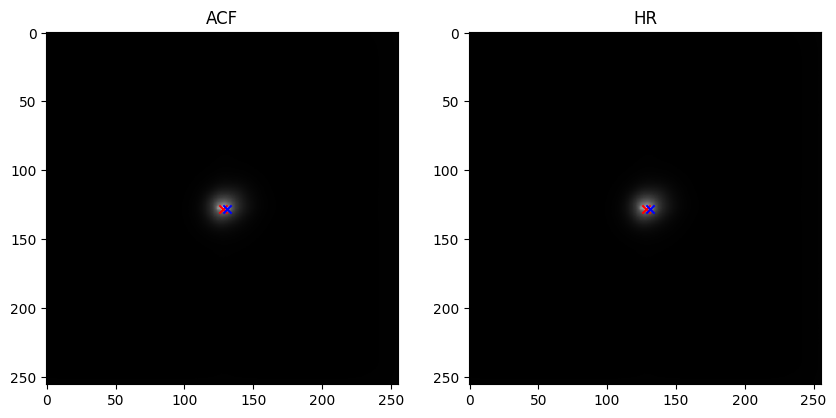

In [31]:
hdul = fits.open(r"D:\22abr22\ACF\ACF-14310-0548_O-I.fits")
header = hdul[0].header
data = hdul[0].data

hdul_01 = fits.open(r"D:\22abr22\HR\HR_image-14310-0548_O-I.fits")  # Mostra informações sobre as extensões do FITS
header_01 = hdul_01[0].header
data_01 = hdul_01[0].data 

(x_max, y_max), _ = position(autocorr)
(x_max_01, y_max_01), _ = position(HR)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray', origin='upper')
plt.scatter(x_max, y_max, color='red', marker='x')
plt.imshow(data_01, cmap='gray', origin='upper')
for i in range(len(pos_acf)):
    plt.scatter(pos_acf[i, 0], pos_acf[i, 1], color='b', marker='x')
plt.title("ACF")

plt.subplot(1 , 2, 2)
plt.imshow(data_01, cmap='gray', origin='upper')
plt.scatter(x_max_01, y_max_01, color='red', marker='x')
plt.imshow(data_01, cmap='gray', origin='upper')
for i in range(len(pos_hr)):
    plt.scatter(pos_hr[i, 0], pos_hr[i, 1], color='b', marker='x')
plt.title("HR")
plt.show()

----

Angular separation calculation

----

In [61]:
JE = 2022.30704 # Julian Epoch
period = 18.757 # Orbit period (years)
a = 0.13544 # Semimajor-axis (arcsec)
i = 144.34 # Orbit inclination (degrees)
Omega = 269.32 # Angle between gama and the ascending node (degrees)
tau = 2005.849 # Time os periastron (BY)      
e = 0.2193 # Eccentricity
w = 359.81 # Longitude of periastron (degrees)

Omega_rad = np.radians(Omega)
w_rad = np.radians(w)
i_rad = np.radians(i)

def byear_to_jyear(tau):
    JD = (tau - 1900.0)*365.242198781 + 2415020.31352
    t = Time(JD, format='jd')
    t = t.jyear

    return t
    
t_jy = byear_to_jyear(tau)

M = (2*np.pi*(JE - t_jy))/period
M = M % (2 * np.pi)

def anomalous_accentricity(M, e):
    E = M
    tol = 1e-8

    for i in range(100):
        f_E = E - e*np.sin(E) - M
        f_prime_E = 1 - e*np.cos(E)
        
        # Evita divisão por zero em casos extremos (e.g., e=1)
        if f_prime_E == 0:
            break
            
        En = E - f_E / f_prime_E

        if abs(En - E) < tol:
            break

        E = En
        if i == 99:
            # Se não convergir em 100 iterações, retorna o último valor
            pass
        
    return E
    
E = anomalous_accentricity(M, e)


def true_anomaly(e, E):
    f_up = np.sqrt(1+e) * np.sin(E/2)
    f_down = np.sqrt(1-e) * np.cos(E/2)
    f = 2 * np.arctan2(f_up, f_down)

    return f
    
phi = true_anomaly(e, E)

def coordinates(phi, a, e, omega_rad, w_rad, i_rad):
    r = (a*(1-e**2))/(1+e*np.cos(phi))

    x = r*(np.cos(omega_rad)*np.cos(w_rad + phi) - np.sin(omega_rad)*np.cos(i_rad)*np.sin(w_rad + phi))
    y = r*(np.sin(omega_rad)*np.cos(w_rad + phi) + np.cos(omega_rad)*np.cos(i_rad)*np.sin(w_rad + phi))
    z = r*(np.sin(w_rad + phi)*np.sin(i_rad))

    rho = np.sqrt(x**2 + y**2)
    theta = np.degrees(np.arctan2(y, x))
    theta = theta % 360

    return rho, theta
    
rho, theta = coordinates(phi, a, e, Omega_rad, w_rad, i_rad)

#for i in rho:
    #print(f'{i:.2f}')

print(f'{rho:.2f}')
print(f'{theta:.2f}')





0.10
330.03


----

Plate scale calc

----

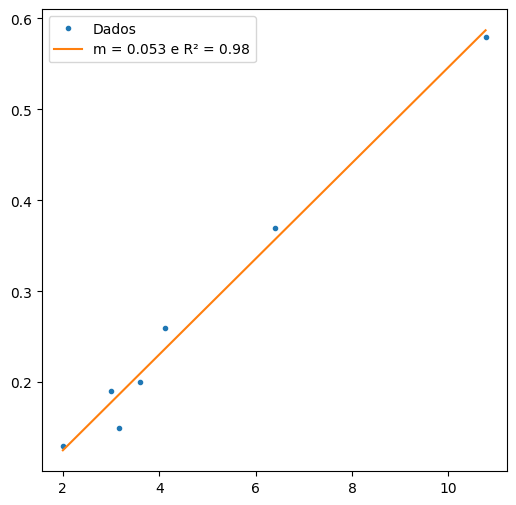

In [7]:
#LE = r"D:\22abr22\LE\LE_image-12283-6146_O-I.fits"

ydata = np.array([0.58, 0.26, 0.13, 0.15, 0.37, 0.19, 0.20])
xdata = np.array([10.77, 4.12, 2, 3.16, 6.40, 3, 3.61])

coef, error, r2_score, Fij = linear_regression(xdata, ydata)

xcalc = np.linspace(xdata.min(), xdata.max(), 100)
ycalc = Fij(xcalc) @ coef

ep = coef[1]
#seeing_value = seeing(LE, ep)
#print(f'seeing = {seeing_value:.2f} "/pixel')

plt.figure(figsize=(6, 6))
plt.plot(xdata, ydata, '.', label='Dados')
plt.plot(xcalc, ycalc, '-', label=f'm = {coef[1]:.3f} e R² = {r2_score:.2f}')
plt.legend()
plt.show()